In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integrate
from scipy.optimize import brentq
import math as math
import numpy.linalg as linalg
from scipy.interpolate import interp1d
from scipy.stats import uniform
import time
import psutil
import os

In [2]:
# Physical costants
electron_charge = 1.602176634e-19 # C
speed_of_light = 299792458 # m/s
alpha = 0.007297
muon_mass = 0.105658374524 #GeV
electron_mass = 0.0005109989461 # GeV
E_exp=2*muon_mass + 0.005

conversion0 = 0.389379e6 #1/GeV --> nanoBarn
conversion1 = (5.34*10**(-19)) #Gev/c ---- > kg*m/s (momentum)
conversion2 = (1.78*10**(-27)) #Gev/c^2 -------> kg (mass)

# Functions
def total_cross_section_nb(s=E_exp**2):
    return (((alpha**2)*np.pi*4/(3*s))*np.sqrt(1-(4*muon_mass**2/s))*(1+(2*muon_mass**2)/s))*conversion0

def differential_cross_section_nb(theta, s=E_exp**2): #rads
    return (((alpha**2)*np.pi*2/(4*s))*np.sqrt(1-(4*muon_mass**2/s))*((1+(4*muon_mass**2/s))+(1-(4*muon_mass**2/s))*np.cos(theta)**2))*conversion0

def pdf_theta(theta, s=E_exp**2): #rads!
    return np.sin(theta)*differential_cross_section_nb(theta, s)

print('Total cross section = ', total_cross_section_nb(E_exp**2))
cost_norm_theta = integrate.quad(lambda theta: pdf_theta(theta),0,np.pi)
print('Normalization pdf = ', cost_norm_theta[0])

def pdf_theta_norm(theta, s=E_exp**2):
    # Rescale both the integration interval and the pdf values
    return (1/cost_norm_theta[0])*pdf_theta((theta*np.pi/180), s)*np.pi/180 

print("Verify normalization: ", integrate.quad(lambda theta: pdf_theta_norm(theta),0,180)[0])

E=np.arange(2*muon_mass, E_exp + 0.1,0.0001) #CoM + 0.1 to show high energy behaviour
s=np.power(E,2)
angles=np.arange(0,180,1)
angles_rad=angles*(np.pi/180)
cos_angles=np.cos(angles_rad)

Total cross section =  586.0378845408211
Normalization pdf =  586.0378845408212
Verify normalization:  0.9999999999999999


In [3]:
# Number of iterations
iterations = 8*10**5
# Load parameters for comparison
process = psutil.Process(os.getpid())

### > HIT or MISS

In [4]:
# HIT OR MISS
def hit_or_miss(distribution, num_samples, x_range, y_range):
    x_samples = np.random.uniform(*x_range, num_samples)
    y_samples = np.random.uniform(*y_range, num_samples)
    hits = y_samples <= distribution(x_samples)
    return x_samples[hits]

angle_range = (np.min(angles), np.max(angles))  # In degrees
pdf_range = (np.min(pdf_theta_norm(angles)), np.max(pdf_theta_norm(angles)))

mem_before_hm = process.memory_info().rss / 1024 / 1024
start_time_hm = time.time()
theta_samples_hm = hit_or_miss(pdf_theta_norm, iterations, angle_range, pdf_range)
end_time_hm = time.time()
mem_after_hm = process.memory_info().rss / 1024 / 1024
    
time_hm = round((end_time_hm - start_time_hm),3)
mem_usage_hm = round((mem_after_hm - mem_before_hm),3)
accepted_hm = round((len(theta_samples_hm)/iterations),3)

print(f"Execution time: {time_hm} seconds")
print(f"Memory usage: {mem_usage_hm} MB")
print(f"Accepted rate: {accepted_hm}")

Execution time: 0.046 seconds
Memory usage: 5.164 MB
Accepted rate: 0.645


### > IMPORTANCE SAMPLING

In [5]:
def importance_sampling(N, pdf_target_norm, proposal_range=(0, 180), proposal_pdf=None):
    theta_samples_prop = np.random.uniform(proposal_range[0], proposal_range[1], iterations)
    
    if proposal_pdf is None:
        proposal_pdf_values = uniform.pdf(theta_samples_prop, proposal_range[0], proposal_range[1] - proposal_range[0])
    else:
        proposal_pdf_values = proposal_pdf(theta_samples_prop)
    
    weights = np.maximum(pdf_target_norm(theta_samples_prop) / proposal_pdf_values, 0)
    weights /= np.sum(weights)
    
    theta_samples_imp = np.random.choice(theta_samples_prop, size=iterations, p=weights)
    
    return theta_samples_imp

mem_before_imp = process.memory_info().rss / 1024 / 1024
start_time_imp = time.time()
theta_samples_imp = importance_sampling(iterations, pdf_theta_norm)
end_time_imp = time.time()
mem_after_imp = process.memory_info().rss / 1024 / 1024

time_imp = round((end_time_imp - start_time_imp),3)
mem_usage_imp = round((mem_after_imp - mem_before_imp),3)
accepted_imp = round((len(theta_samples_imp)/iterations),3)

print(f"Execution time: {time_imp} seconds")
print(f"Memory usage: {mem_usage_imp} MB")
print(f"Accepted rate: {accepted_imp}")

Execution time: 0.215 seconds
Memory usage: 43.715 MB
Accepted rate: 1.0


### > METROPOLIS

In [6]:
def metropolis_hastings(distribution, initial_sample, interations, passes, s=E_exp**2):
    current_sample = initial_sample
    samples = [current_sample]
    accepted = 0
    for i in range(iterations):
        new_sample = np.random.normal(current_sample, passes) #proposal distribution
        acceptance_ratio = distribution(new_sample, s) / distribution(current_sample, s)
        if (np.random.uniform(0,1,1) <= acceptance_ratio):
            current_sample = new_sample
            accepted += 1
        samples.append(current_sample)
    return np.asarray(samples),accepted

initial_sample = 90
passes = 7.5

mem_before_mh = process.memory_info().rss / 1024 / 1024
start_time_mh = time.time()
theta_samples_mh, accepted = metropolis_hastings(pdf_theta_norm, initial_sample, iterations, passes)
end_time_mh = time.time()
mem_after_mh = process.memory_info().rss / 1024 / 1024

time_mh = round((end_time_mh - start_time_mh),3)
mem_usage_mh = round(mem_after_mh - mem_before_mh,3)
accepted_mh = round((len(theta_samples_mh)/iterations),3)

print(f"Execution time: {time_mh} seconds")
print(f"Memory usage: {mem_usage_mh} MB")
print(f"Accepted rate: {accepted_mh}")

Execution time: 9.28 seconds
Memory usage: 2.613 MB
Accepted rate: 1.0


### > INVERSE SAMPLING

In [7]:
def inverse_sampling(iterations):
    def pdf_cos(z, s=E_exp**2):
        return (((alpha**2) * np.pi * 2 / (4 * s)) * np.sqrt(1 - (4 * muon_mass**2 / s)) *
                ((1 + (4 * muon_mass**2 / s)) + (1 - (4 * muon_mass**2 / s)) * z**2)) * 0.389379e6

    cost_norm_cos = integrate.quad(lambda z: pdf_cos(z), -1, 1)[0]

    def pdf_cos_norm(z, s=E_exp**2):
        return pdf_cos(z, s) / cost_norm_cos

    def cdf_zeros(y, x, s=E_exp**2):
        cost = ((alpha**2) * np.pi * 2 / (4 * s)) * np.sqrt(1 - (4 * muon_mass**2 / s)) * conversion0
        norm_cost = total_cross_section_nb(s)
        return (-cost / norm_cost) * (1/3 * (1 - (4 * muon_mass**2 / s)) *
                                      y**3 + (1 + (4 * muon_mass**2 / s)) * y - 4/3 * (1 + 2 * muon_mass**2 / s)) - x

    r_samples = np.random.uniform(0, 1, iterations)
    theta_samples_is = [brentq(cdf_zeros, -1, 1, args=(r,)) for r in r_samples]

    return theta_samples_is

mem_before_is = process.memory_info().rss / 1024 / 1024
start_time_is = time.time()
theta_samples_is = inverse_sampling(iterations)
end_time_is = time.time()
mem_after_is = process.memory_info().rss / 1024 / 1024

time_is = round((end_time_is - start_time_is),3)
mem_usage_is = round((mem_after_is - mem_before_is),3)
accepted_is = round((len(theta_samples_is)/iterations),3)
theta_samples_isc = 180*np.arccos(theta_samples_is)/np.pi

print(f"Execution time: {time_is} seconds")
print(f"Memory usage: {mem_usage_is} MB")
print(f"Accepted rate: {accepted_is}")

Execution time: 21.636 seconds
Memory usage: 22.0 MB
Accepted rate: 1.0


### > SEQUENTIAL MONTE CARLO

In [8]:
def sequential_monte_carlo(iterations, pdf_target_norm, proposal_range=(0, 180), steps=1):
    theta_samples_se = np.random.uniform(proposal_range[0], proposal_range[1], iterations)
    
    for step in range(steps):
        weights = pdf_target_norm(theta_samples_se)
        weights /= np.sum(weights)
        theta_samples_se = np.random.choice(theta_samples_se, size=iterations, p=weights)
    
    return theta_samples_se

mem_before_se = process.memory_info().rss / 1024 / 1024
start_time_se = time.time()
theta_samples_se = sequential_monte_carlo(iterations, pdf_theta_norm, steps=1)
end_time_se = time.time()
mem_after_se = process.memory_info().rss / 1024 / 1024

time_se = round((end_time_se - start_time_se),3)
mem_usage_se = round((mem_after_se - mem_before_se),3)
accepted_se = round((len(theta_samples_se)/iterations),3)

print(f"Execution time: {time_se} seconds")
print(f"Memory usage: {mem_usage_se} MB")
print(f"Accepted rate: {accepted_se}")

Execution time: 0.203 seconds
Memory usage: 18.34 MB
Accepted rate: 1.0


### > STRATIFIED SAMPLING

In [9]:
def stratified_sampling(iterations, pdf_target_norm, range_start=0, range_end=180, strata=10):
    
    theta_samples_st = np.array([])
    total_integral = integrate.quad(pdf_target_norm, range_start, range_end)[0]

    for stratum in range(strata):
        stratum_start = range_start + (range_end - range_start) * (stratum / strata)
        stratum_end = range_start + (range_end - range_start) * ((stratum + 1) / strata)
        
        stratum_integral = integrate.quad(pdf_target_norm, stratum_start, stratum_end)[0]
        
        stratum_samples_count = int((stratum_integral / total_integral) * iterations)
        
        if stratum_samples_count > 0:
            stratum_samples = np.random.uniform(stratum_start, stratum_end, stratum_samples_count)
            theta_samples_st = np.concatenate((theta_samples_st, stratum_samples))

    return theta_samples_st
    
strata = 100

mem_before_st = process.memory_info().rss / 1024 / 1024
start_time_st = time.time()
theta_samples_st = stratified_sampling(iterations, pdf_theta_norm, strata=strata)
end_time_st = time.time()
mem_after_st = process.memory_info().rss / 1024 / 1024

time_st = round((end_time_st - start_time_st),3)
mem_usage_st = round((mem_after_st - mem_before_st),3)
accepted_st = round((len(theta_samples_st)/iterations),3)

print(f"Execution time: {time_st} seconds")
print(f"Memory usage: {mem_usage_st} MB")
print(f"Accepted rate: {accepted_st}")

Execution time: 0.033 seconds
Memory usage: 0.0 MB
Accepted rate: 1.0


### > PLOTTING

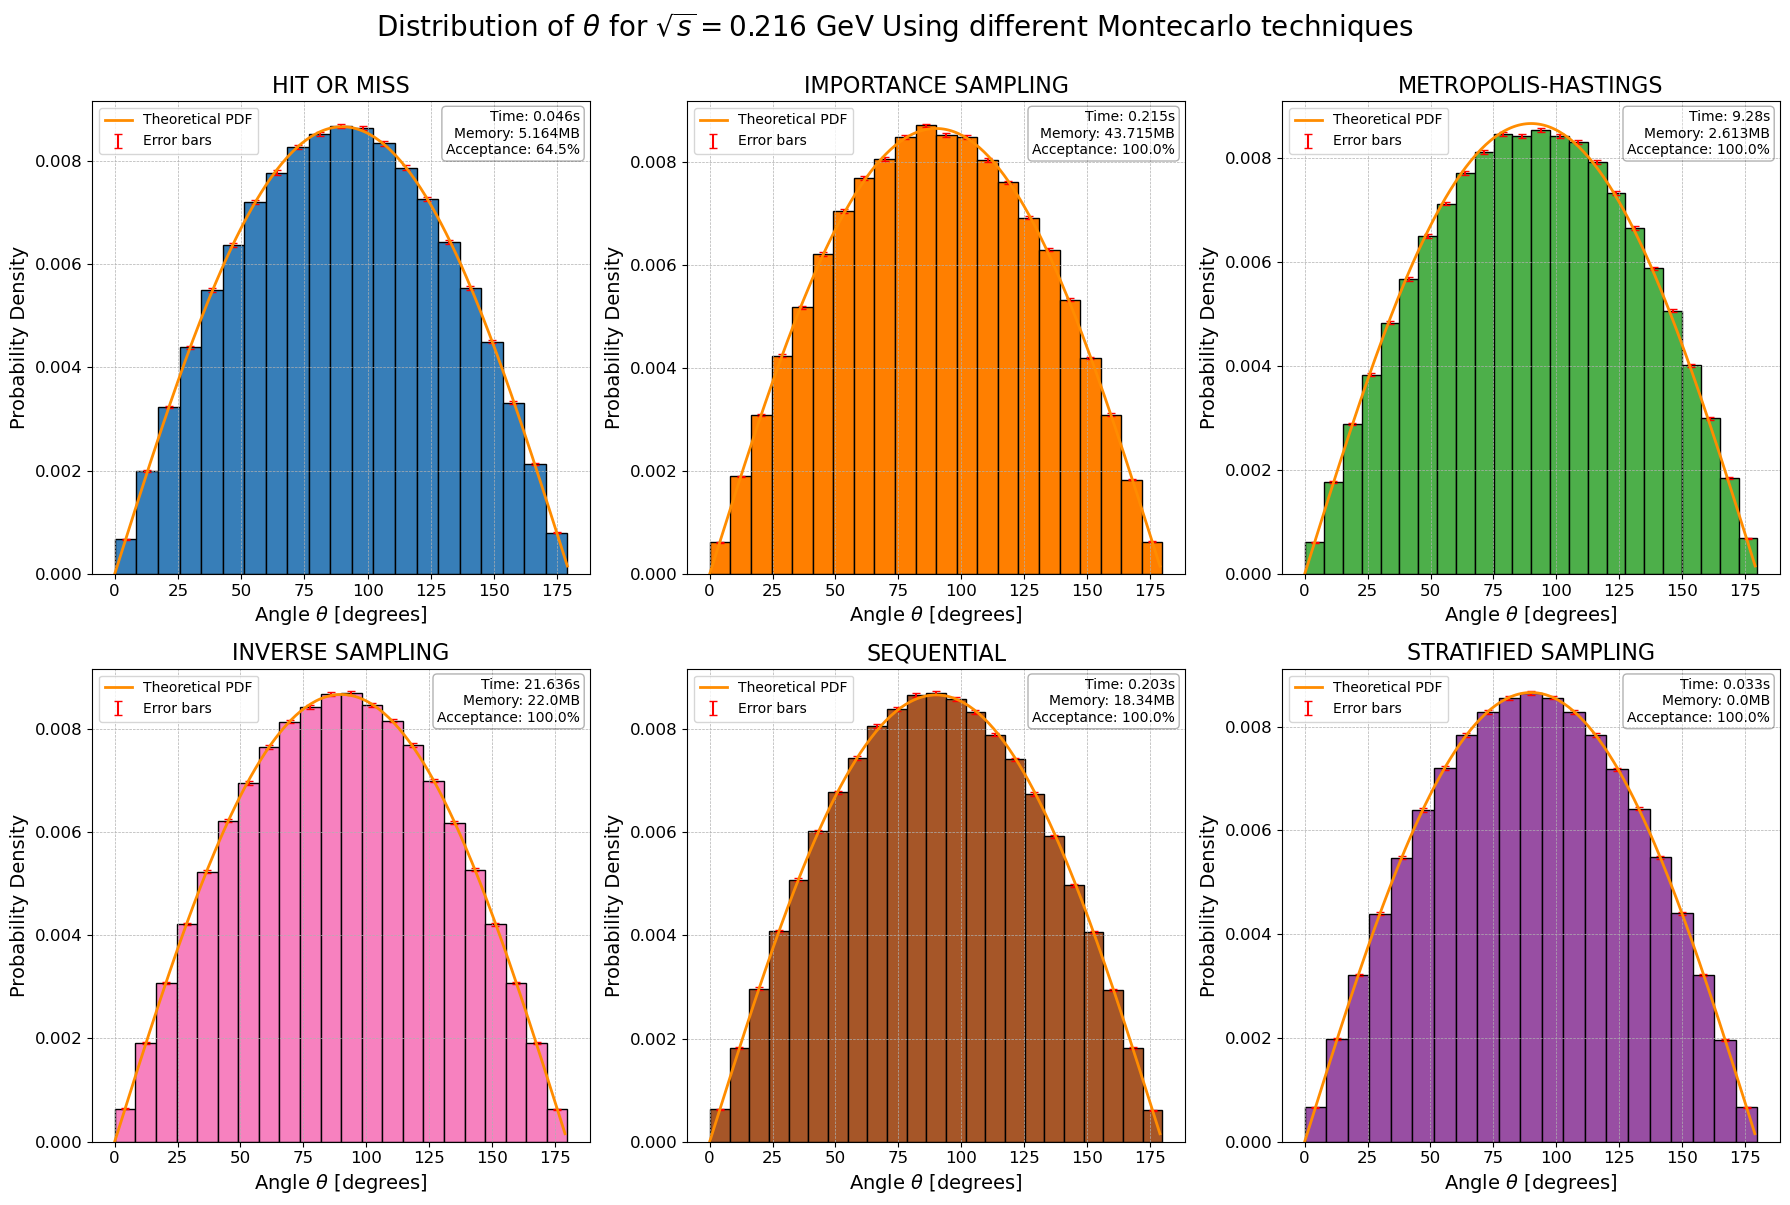

In [10]:
#Plot
names = ["HIT OR MISS","IMPORTANCE SAMPLING","METROPOLIS-HASTINGS","INVERSE SAMPLING","SEQUENTIAL","STRATIFIED SAMPLING"]
methods = ["hm","imp","mh","isc","se","st"]
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3']
times = [time_hm, time_imp, time_mh, time_is, time_se, time_st]
mem_usages = [mem_usage_hm, mem_usage_imp, mem_usage_mh, mem_usage_is, mem_usage_se, mem_usage_st]
acceptances = [accepted_hm, accepted_imp, accepted_mh, accepted_is, accepted_se, accepted_st]

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (method, time, mem_usage, acceptance) in enumerate(zip(methods, times, mem_usages, acceptances)):
    dataset = globals()[f'theta_samples_{method}']
    
    counts, bins, patches = axs[i].hist(dataset, bins="doane", density=True, color=colors[i], edgecolor='black')
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_width = np.diff(bins)
    total_samples = len(dataset)
    errors = np.sqrt(counts / (total_samples * bin_width))
    axs[i].errorbar(bin_centers, counts, yerr=errors, fmt='none', ecolor='r', capsize=3, label='Error bars')
    
    axs[i].plot(angles, pdf_theta_norm(angles), color='darkorange', linewidth=2, label="Theoretical PDF")
    axs[i].set_title(names[i], fontsize=16)
    axs[i].set_xlabel(r'Angle $\theta$ [degrees]', fontsize=14)
    axs[i].set_ylabel('Probability Density', fontsize=14)
    axs[i].legend(loc='upper left', fontsize=10)
    axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[i].tick_params(axis='both', which='major', labelsize=12)

    info_text = f"Time: {time}s\nMemory: {mem_usage}MB\nAcceptance: {acceptance*100:.1f}%"
    axs[i].text(0.98, 0.98, info_text, transform=axs[i].transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.3, boxstyle="round,pad=0.3"))

fig.suptitle(r'Distribution of $\theta$ for $\sqrt{s}=$' + str(round(E_exp, 3)) + ' GeV Using different Montecarlo techniques',
             fontsize=20, y=1.0)
plt.tight_layout()
plt.show()

### > BABAYAGA COMPARISON

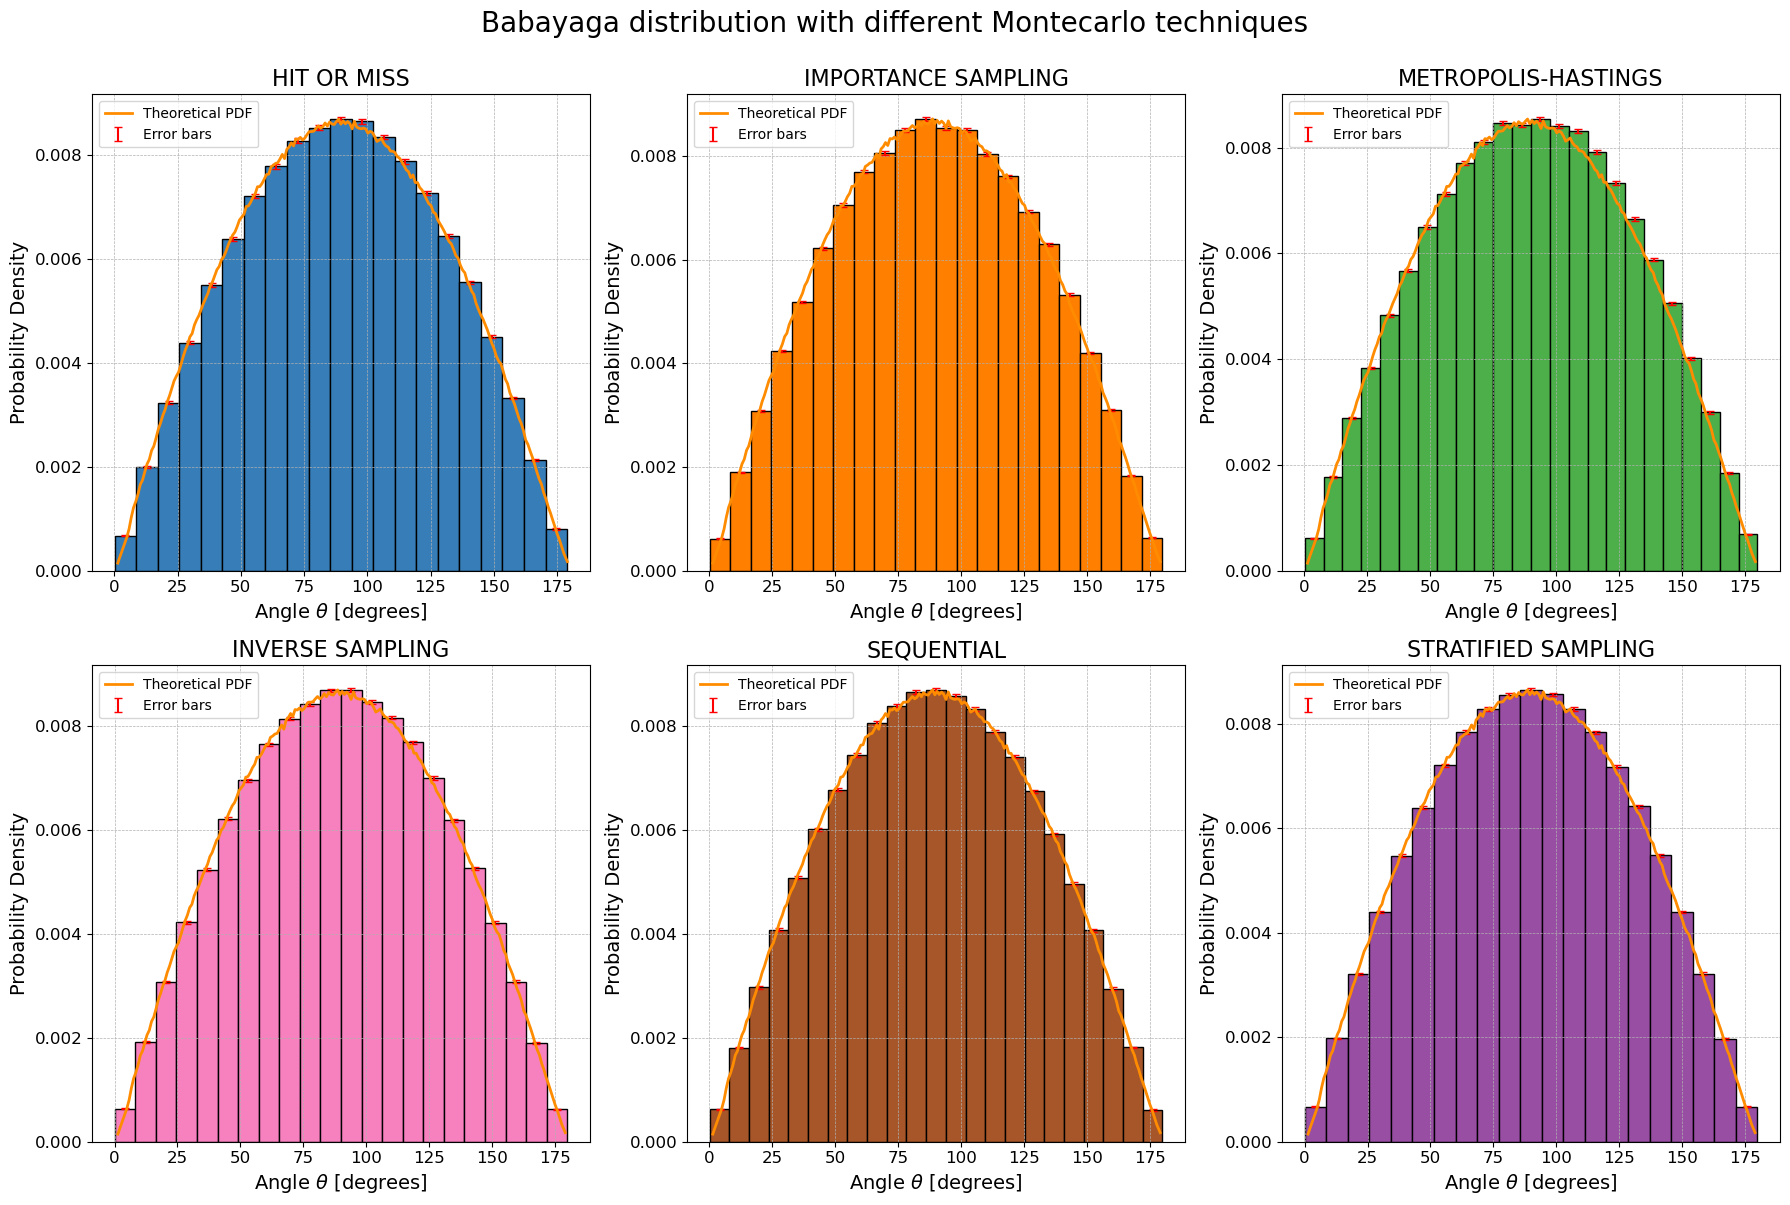

In [11]:
Babayaga = np.loadtxt("matched_el_th_exp_200.txt").T


fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (method, time, mem_usage, acceptance) in enumerate(zip(methods, times, mem_usages, acceptances)):
    dataset = globals()[f'theta_samples_{method}']
    
    counts, bins, patches = axs[i].hist(dataset, bins="doane", density=True, color=colors[i], edgecolor='black')

    k = (np.max(Babayaga[1])) / np.max(counts)
    baba_plotted = Babayaga[1] / k
    centers = [Babayaga[0][i] + (Babayaga[0][i+1] - Babayaga[0][i]) / 2 for i in np.arange(0, len(Babayaga[0]) - 1)]
    centers.append(Babayaga[0][-1] + (Babayaga[0][-1] - Babayaga[0][-2]))

    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_width = np.diff(bins)
    total_samples = len(dataset)
    errors = np.sqrt(counts / (total_samples * bin_width))
    axs[i].errorbar(bin_centers, counts, yerr=errors, fmt='none', ecolor='r', capsize=3, label='Error bars')
    
    axs[i].plot(centers, baba_plotted, color='darkorange', linewidth=2, label="Babayaga PDF")
    axs[i].set_title(names[i], fontsize=16)
    axs[i].set_xlabel(r'Angle $\theta$ [degrees]', fontsize=14)
    axs[i].set_ylabel('Probability Density', fontsize=14)
    axs[i].legend(loc='upper left', fontsize=10)
    axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[i].tick_params(axis='both', which='major', labelsize=12)

fig.suptitle(r'Babayaga distribution with different Montecarlo techniques',
             fontsize=20, y=1.0)
plt.tight_layout()
plt.show()

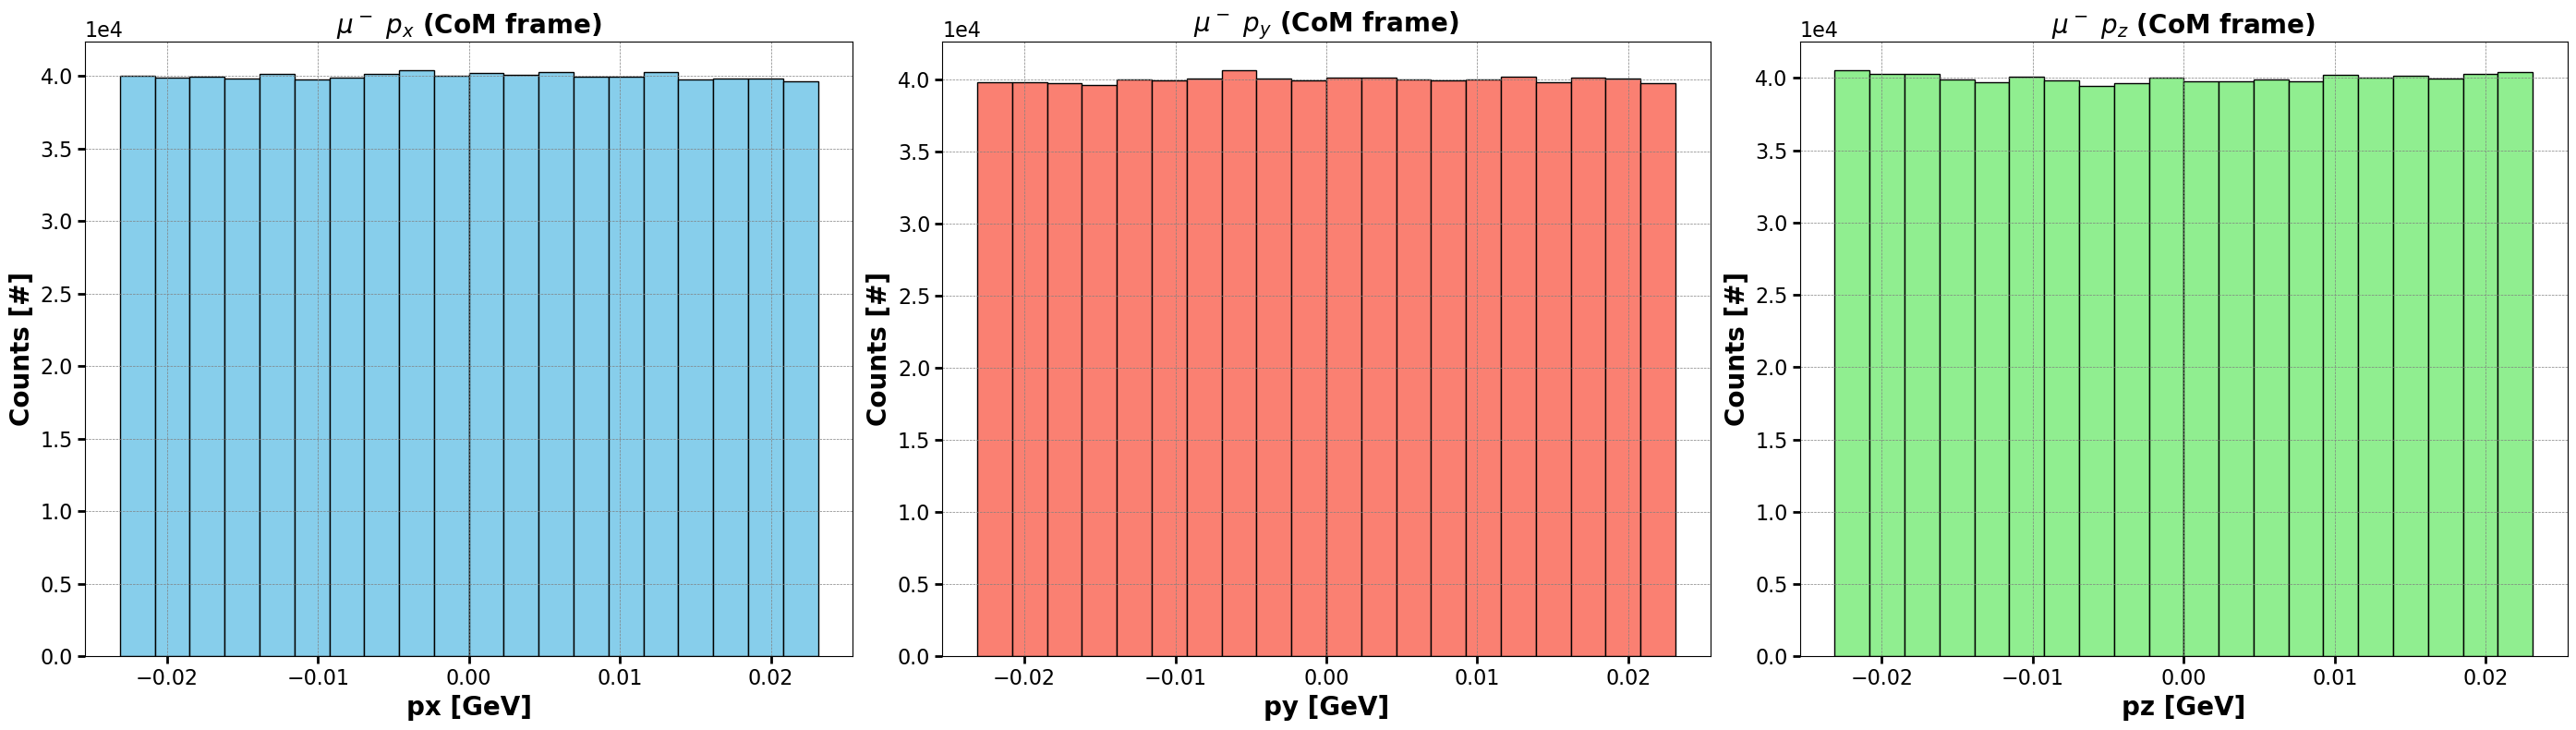

   Anti_muon_px  Anti_muon_py  Anti_muon_pz   Muon_px   Muon_py   Muon_pz
0     -0.018780     -0.012298      0.005534  0.018780  0.012298 -0.005534
1      0.009281     -0.018884     -0.009581 -0.009281  0.018884  0.009581
2     -0.010998     -0.020173      0.002575  0.010998  0.020173 -0.002575
3     -0.019203      0.010509     -0.007440  0.019203 -0.010509  0.007440
4     -0.005780     -0.015635      0.016022  0.005780  0.015635 -0.016022


In [12]:
%precision 6
theta = theta_samples_isc
N_samples = len(theta)
phi = 360*np.random.random(N_samples)
p_1 = np.sqrt(E_exp**2/4 - muon_mass**2)
momenta=pd.DataFrame(columns=['Anti_muon_px','Anti_muon_py','Anti_muon_pz','Muon_px','Muon_py','Muon_pz'])

sin_theta_c = np.sin(theta*(np.pi/180))
cos_theta_c = np.cos(theta*(np.pi/180))
sin_phi_c = np.sin(phi*(np.pi/180))
cos_phi_c = np.cos(phi*(np.pi/180))

momenta['Anti_muon_px'] = p_1*cos_phi_c*sin_theta_c
momenta['Anti_muon_py'] = p_1*sin_phi_c*sin_theta_c
momenta['Anti_muon_pz'] = p_1*cos_theta_c
momenta['Muon_px'] = - momenta['Anti_muon_px']
momenta['Muon_py'] = - momenta['Anti_muon_py']
momenta['Muon_pz'] = - momenta['Anti_muon_pz']

momenta.to_csv("Momenta_CoM.csv", index=False, index_label=False)
momenta = pd.read_csv("Momenta_CoM.csv")

fig, ax = plt.subplots(1, 3, figsize=(28, 8))
titles = [r'$\mu^-$ $p_x$ (CoM frame)', r'$\mu^-$ $p_y$ (CoM frame)', r'$\mu^-$ $p_z$ (CoM frame)']
colors = ['skyblue', 'salmon', 'lightgreen']

for i, coord in enumerate(['Muon_px', 'Muon_py', 'Muon_pz']):
    ax[i].hist(momenta[coord], bins=20, color=colors[i], edgecolor='black')
    ax[i].set_title(titles[i], fontsize=20, fontweight='bold')
    ax[i].set_ylabel(r"Counts [#]", fontsize=20, fontweight='bold')
    ax[i].set_xlabel(f'{coord[-2:]} [GeV]', fontsize=20, fontweight='bold')
    ax[i].tick_params(labelsize=16, length=6, width=2)
    ax[i].ticklabel_format(style='sci', axis='y', scilimits=(-3, 3))
    ax[i].yaxis.get_offset_text().set_fontsize(16)
    ax[i].grid(visible=True, which='major', color='grey', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
print(momenta.head())